# Save

In [81]:
import dill
dill.dump_session('notebook_env.db')

ValueError: ctypes objects containing pointers cannot be pickled

# Load

In [1]:
import dill
dill.load_session('notebook_env.db')

In [2]:
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

from hyperopt import fmin, hp, tpe, Trials

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

import copy
import time
import datetime

In [103]:
#data = pd.read_csv("Diabetes study file cleaned.csv", header = "infer")
#data7 = pd.read_csv("Diabetes Study File 10K Dec 7 2017 Flattened.csv", header = "infer")
#data14 = pd.read_csv("Diabetes Study File 10K Dec 14 2017 Flattened.csv", header = "infer")

dataAll = pd.read_csv("Diabetes Study File Nov 28 2017.csv", header = "infer")

print (dataAll.columns)

C:\Users\ONTARIO\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (20,36,38,39,40,41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index(['Patient_ID', 'Age_at_Exam', 'sBP', 'sBP_Date', 'BMI', 'BMI_Date',
       'LDL', 'LDL_Date', 'HDL', 'HDL_Date', 'A1c', 'A1c_Date', 'TG',
       'TG_Date', 'FBS', 'FBS_Date', 'FBS>DM', 'Total_Cholesterol',
       'Total_Cholesterol_Lab_Date', 'Diabetes', 'DM_OnsetDate', 'Depression',
       'Depression_OnsetDate', 'HTN', 'HTN_OnsetDate', 'OA', 'OA_OnsetDate',
       'COPD', 'COPD_Date', 'All_Medications', 'Hypertension_Medications',
       'Hypertension_Medications_First_Instance', 'Corticosteroids',
       'Corticosteroids_first_instance', 'Sex', 'leastO(A1c_Date)',
       'leastO(DM_OnsetDate)', 'leastO(FBS_Date)', 'LeastOfAll', 'A1C_BEF_DM',
       'FBS_BEF_DM', 'DM_Onset_Revised', 'DM_Onset_Revised_1YrPrior'],
      dtype='object')


In [123]:
#data = data7.append(data14).drop_duplicates()
data = dataAll
data = data[["Age_at_Exam","sBP","BMI","LDL","HDL","A1c", "FBS>DM","TG","FBS","Total_Cholesterol","Depression","HTN","OA","COPD",
            "Corticosteroids","Sex","Hypertension_Medications","Diabetes"]]

data = data[(data["FBS>DM"]==0)|(data["Diabetes"]==0)]
data = data[(data ["FBS"] <= 6.9) & (data["FBS"] >= 5.6)&(data["A1c"] < 6.5)]

#Creating a dummy variable for sex
data ["Sex"] = data["Sex"] == "Male"
#data ["DIABETES"] = data ["DIABETES"] == "Yes"
#data ["HDL"] = data["Total_Cholesterol"]-data["LDL"]-data["TG"]/5
data ["Corticosteroids"] = data ["Corticosteroids"].notnull()
data = data.reset_index(drop = True)

# Flatten Hypertension Medication into Drug Type features

In [124]:
medication_types = pd.read_csv("Hypertension Medication Type List.csv", header = "infer")
for i in range(len(medication_types)):
    data[medication_types.iloc[i,1]] = 0
        
for i in range (len(data)):
    for j in range (len(medication_types)):
        if (type(data.loc[:,"Hypertension_Medications"][i])== str):
            if (medication_types.iloc[j,0] in data.loc[:,"Hypertension_Medications"][int (i)]):
                data.loc[:,medication_types.iloc[j,1]][i] = 1

data = data.drop (["Hypertension_Medications", "FBS>DM"], axis = 1)

print (data)

C:\Users\ONTARIO\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


       Age_at_Exam    sBP   BMI  LDL  HDL  A1c   TG  FBS  Total_Cholesterol  \
0             69.0  140.0  26.0  3.3  1.0  5.9  1.7  6.2                5.2   
1             52.0  116.0  66.0  2.9  1.7  6.4  0.8  5.6                5.0   
2             63.0  122.0  28.0  2.1  1.3  5.4  1.1  5.7                3.8   
3             61.0  132.0  41.0  5.4  1.5  6.0  1.2  5.7                7.4   
4             73.0  148.0  50.3  1.5  1.1  5.4  1.7  6.5                3.4   
5             62.0  140.0  25.8  2.4  1.3  5.8  1.3  5.8                4.3   
6             76.0  120.0  36.0  3.4  1.2  6.1  1.4  5.9                5.3   
7             38.0  107.0  31.7  2.4  0.8  5.8  1.1  5.8                3.7   
8             67.0  116.0  21.9  2.8  1.9  6.2  2.0  6.1                5.5   
9             76.0  132.0  28.0  2.1  0.9  6.0  1.9  5.7                3.9   
10            70.0  132.0  26.0  1.6  1.1  6.0  1.6  6.1                3.5   
11            72.0  125.0  26.0  1.1  1.0  6.0  0.9 

# Save flattened features to save time for future use

In [126]:
data.to_csv("Diabetes Study File Nov 28 2017 - Flattened.csv")

# Read flattened features

In [3]:
data = pd.read_csv("Diabetes Study File Nov 28 2017 - Flattened.csv", header = "infer")

# Handlin Missing Data

In [4]:
print (data.isnull().sum())

Unnamed: 0                    0
Age_at_Exam                   0
sBP                          63
BMI                           0
LDL                         220
HDL                         440
A1c                           0
TG                          470
FBS                           0
Total_Cholesterol          1259
Depression                    0
HTN                           0
OA                            0
COPD                          0
Corticosteroids               0
Sex                           0
Diabetes                      0
Ace Inhibitor                 0
Alpha Blocker                 0
ARB                           0
Beta Blocker                  0
Calcium Channel Blocker       0
Diuretic                      0
Other                         0
dtype: int64


In [5]:
data = data.fillna(data.mean())

# Outlier detection using LOF

In [6]:
lof = LocalOutlierFactor (n_neighbors = 1, contamination = 0.05, metric = "manhattan")
outliers = lof.fit_predict(data.loc[:,data.columns != "DIABETES"])

outlierDF = pd.DataFrame(outliers)
data = data[outlierDF[0]==1]
print (data.shape)

(60681, 24)


# Check for zero-variance

In [7]:
varianceDF = pd.DataFrame(columns = ["Feature", "Percent_unique", "Freq_Ratio"])
for i in data:
    value, count = np.unique(data[i], return_counts = True)
    count = np.flip(np.sort(count), axis = 0)
    tempDF = pd.DataFrame(columns = ["Feature", "Percent_unique", "Freq_Ratio"])
    tempDF.loc[0] = [i, len(value)/len(data[i])*100.0, count[0]/count[1]]
    varianceDF = varianceDF.append(tempDF)
    
print (varianceDF)
# get rid fo all with FBS > DM of 1

                   Feature  Percent_unique  Freq_Ratio
0               Unnamed: 0      100.000000    1.000000
0              Age_at_Exam        0.120301    1.016452
0                      sBP        0.263674    1.194864
0                      BMI        0.861884    1.025343
0                      LDL        0.130189    1.042500
0                      HDL        0.075806    1.055618
0                      A1c        0.052735    1.009721
0                       TG        0.192812    1.051882
0                      FBS        0.023071    1.055133
0        Total_Cholesterol        0.159852    1.026938
0               Depression        0.003296    3.574519
0                      HTN        0.003296    1.976602
0                       OA        0.003296    2.157180
0                     COPD        0.003296    9.219097
0          Corticosteroids        0.003296    2.663648
0                      Sex        0.003296    1.079113
0                 Diabetes        0.003296    5.510138
0         

# Dropping zero-variance features

In [8]:
#Features dropped for having too high of a frequency ratio between first and second most common items
data = data.drop(["COPD","Alpha Blocker","Other"], axis = 1)

In [9]:
corr_matrix = data.corr().abs()

correlated_featres = []
for column in corr_matrix:
    tempList = corr_matrix.index[corr_matrix[column] > 0.8].tolist()
    if (len(tempList)>1 and tempList not in correlated_featres):
        correlated_featres.append(tempList)
print ("Highly correlated features:", correlated_featres)

Highly correlated features: [['LDL', 'Total_Cholesterol']]


In [10]:
#Dropping Total_Cholesterol because it is the total of HDL, LDL, and TG/5, however HDL and TG are not highly correlated features
data = data.drop (["Total_Cholesterol"], axis = 1)

In [11]:
linear_combo = np.linalg.qr(data)[1]
linear_combo = linear_combo.sum(axis = 1)

bad_features = []

for i in range(len(data.columns.values)):
    if abs(linear_combo[i]) < 1.e-10:
        bad_features.append(data.columns.values[i])

print("Linearly correlated features:", bad_features)

Linearly correlated features: []


# Normalize data between 0 and 1

In [12]:
data_values = data.values
dataColumm = data.columns.values
min_max_scaler = preprocessing.MinMaxScaler()
data = pd.DataFrame(min_max_scaler.fit_transform(data_values), columns = dataColumm)

C:\Users\ONTARIO\Anaconda3\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


# Imbalanced dataset

In [13]:
print (data["Diabetes"].value_counts())

0.0    51360
1.0     9321
Name: Diabetes, dtype: int64


# Split data into testing and training sets

In [14]:
X = data.loc[:,data.columns != "Diabetes"]
Y = data["Diabetes"]

X_train, X_test, y_train, y_test = train_test_split (X,Y,test_size = 0.3)

In [15]:
tpe_trials = Trials()
tpe_algo = tpe.suggest

run_counter = 0

In [16]:
def RFHyperoptLoss (params):
    params["n_estimators"] = round(params["n_estimators"])
    #params["max_depth"] = round(params["max_depth"])

    model = RandomForestClassifier(**params)
    
    y_pred = cross_val_predict (model, X_train, y_train.values.ravel(), cv = 10)
    
    out = f1_score(y_train.values.ravel(), y_pred)
    
    global run_counter, start_time, hyperopt_iterations
    run_counter += 1
    time_elapsed = time.time()-start_time
    print ("running iteration:",run_counter,
           "|time elapsed:", datetime.timedelta(seconds = round(time_elapsed)),
           "|estimated completion time:", time.ctime(time_elapsed/float(run_counter)*hyperopt_iterations+start_time),
           end = "\r")
    
    return 1-out

def RFHyperopt (iterations, params):
    global run_counter
    run_counter += 1

    tpe_best = fmin(fn = RFHyperoptLoss, space = params, algo = tpe_algo, trials= tpe_trials, max_evals = iterations)

    print (tpe_best)
    return tpe_best

# Define the parameter space and run Hyperopt training

In [17]:
start_time = time.time()

#param_space = {"n_estimators": hp.quniform("n_estimators",10,100, 1),
#                "max_depth": hp.quniform("max_dept", 1,15, 1),
#                "learning_rate": hp.loguniform("learning_rate",0.01,1)}

param_space = {"n_estimators": hp.quniform("n_estimators",100,1000, 1),
                "max_depth": hp.quniform("max_dept", 1,30, 1),
                "n_jobs": -1,}
hyperopt_iterations = 2000

best_params = RFHyperopt(hyperopt_iterations, param_space)

C:\Users\ONTARIO\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


C:\Users\ONTARIO\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


C:\Users\ONTARIO\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


C:\Users\ONTARIO\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


C:\Users\ONTARIO\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


{'max_dept': 18.0, 'n_estimators': 559.0}day, 17:41:06 |estimated completion time: Wed Dec 19 05:16:23 2018


# Rearrange hyperparameters for trials into table form

In [19]:
#tpe_results = pd.DataFrame({"accuracy":[1-x["loss"] for x in tpe_trials.results],
#                            "iteration":tpe_trials.idxs_vals[0]["learning_rate"],
#                            "learning_rate":tpe_trials.idxs_vals[1]["learning_rate"],
#                            "max_dept":tpe_trials.idxs_vals[1]["max_dept"],
#                            "n_estimators":tpe_trials.idxs_vals[1]["n_estimators"],
#                            "min_child_weight":tpe_trials.idxs_vals[1]["min_child_weight"],
#                            "subsample":tpe_trials.idxs_vals[1]["subsample"],
#                            "gamma":tpe_trials.idxs_vals[1]["gamma"],
#                            "colsample_bytree":tpe_trials.idxs_vals[1]["colsample_bytree"],})

tpe_results = pd.DataFrame({"F1":[1-x["loss"] for x in tpe_trials.results],
                            "iteration":[x["tid"] for x in tpe_trials.trials],
                            "max_dept":[x["misc"]["vals"]["max_dept"][0] for x in tpe_trials.trials],
                            "n_estimators":[x["misc"]["vals"]["n_estimators"][0] for x in tpe_trials.trials]})

print (tpe_results)
print (best_params)
print (tpe_results.loc[:,"F1"].max())

            F1  iteration  max_dept  n_estimators
0     1.000000          0      18.0         559.0
1     1.000000          1      12.0         979.0
2     1.000000          2      25.0         104.0
3     1.000000          3      14.0         780.0
4     1.000000          4       9.0         355.0
5     1.000000          5      25.0         300.0
6     0.599406          6       2.0         614.0
7     1.000000          7      29.0         359.0
8     0.999924          8       6.0         507.0
9     1.000000          9      21.0         360.0
10    1.000000         10      17.0         719.0
11    1.000000         11      12.0         406.0
12    1.000000         12      20.0         426.0
13    0.000000         13       1.0         277.0
14    1.000000         14      16.0         456.0
15    0.999848         15       3.0         873.0
16    1.000000         16      14.0         906.0
17    1.000000         17      14.0         319.0
18    0.999848         18       3.0         896.0


# Hyperopt trial value graphs by iteration

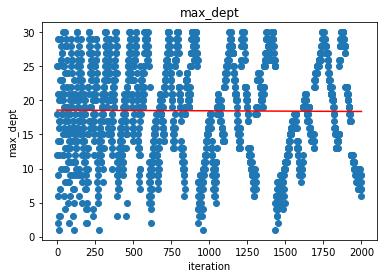

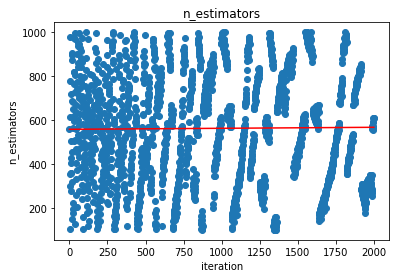

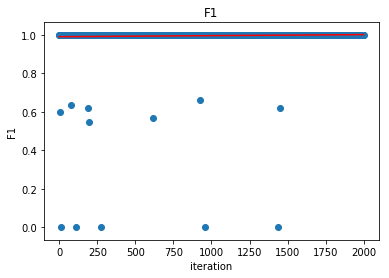

In [20]:
x = np.linspace(0,hyperopt_iterations,hyperopt_iterations)

plt.scatter(tpe_results.loc[:,"iteration"], tpe_results.loc[:,"max_dept"])
plt.title("max_dept")
plt.xlabel("iteration")
plt.ylabel("max_dept")
slope, intercept, r, p, std_err = stats.linregress(tpe_results.loc[:,"iteration"], tpe_results.loc[:,"max_dept"])
plt.plot(x, slope*x+intercept, color = "red")
plt.show()

plt.scatter(tpe_results.loc[:,"iteration"], tpe_results.loc[:,"n_estimators"])
plt.title("n_estimators")
plt.xlabel("iteration")
plt.ylabel("n_estimators")
slope, intercept, r, p, std_err = stats.linregress(tpe_results.loc[:,"iteration"], tpe_results.loc[:,"n_estimators"])
plt.plot(x, slope*x+intercept, color = "red")
plt.show()

plt.scatter(tpe_results.loc[:,"iteration"], tpe_results.loc[:,"F1"])
plt.title("F1")
plt.xlabel("iteration")
plt.ylabel("F1")
slope, intercept, r, p, std_err = stats.linregress(tpe_results.loc[:,"iteration"], tpe_results.loc[:,"F1"])
plt.plot(x, slope*x+intercept, color = "red")
plt.show()

# Hyperopt trial value graphs by accuracy

C:\Users\ONTARIO\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  """


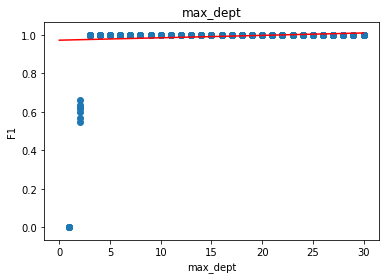

C:\Users\ONTARIO\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  


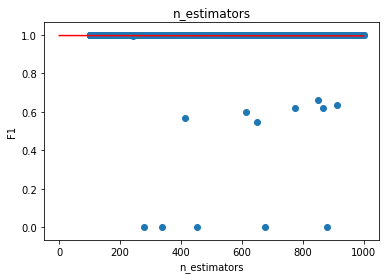

F1                1.0
iteration         0.0
max_dept         18.0
n_estimators    559.0
Name: 0, dtype: float64


In [21]:
plt.scatter(tpe_results.loc[:,"max_dept"], tpe_results.loc[:,"F1"])
plt.title("max_dept")
plt.ylabel("F1")
plt.xlabel("max_dept")
x = np.linspace(0, tpe_results.loc[:,"max_dept"].max(),tpe_results.loc[:,"max_dept"].max())
slope, intercept, r, p, std_err = stats.linregress(tpe_results.loc[:,"max_dept"], tpe_results.loc[:,"F1"])
plt.plot(x, slope*x+intercept, color = "red")
plt.show()

plt.scatter(tpe_results.loc[:,"n_estimators"], tpe_results.loc[:,"F1"])
plt.title("n_estimators")
plt.ylabel("F1")
plt.xlabel("n_estimators")
x = np.linspace(0, tpe_results.loc[:,"n_estimators"].max(),tpe_results.loc[:,"n_estimators"].max())
slope, intercept, r, p, std_err = stats.linregress(tpe_results.loc[:,"n_estimators"], tpe_results.loc[:,"F1"])
plt.plot(x, slope*x+intercept, color = "red")
plt.show()

print(tpe_results.loc[tpe_results["F1"].idxmax()])

# Best Params

In [26]:
final_params = copy.deepcopy(best_params)
del final_params["max_dept"]
#final_params["max_depth"] = round(best_params["max_dept"])
#final_params["n_estimators"] = round(best_params["n_estimators"])
final_params["max_depth"] = 22
final_params["n_estimators"] = 387

model = RandomForestClassifier(**final_params)

score = cross_validate(estimator= model, X = X_train, y = y_train.values.ravel(), cv = 10)
avg_score = np.mean(score["test_score"])
train_time = np.mean(score["fit_time"])
test_time = np.mean(score["score_time"])

y_pred = cross_val_predict (model, X_test, y_test, cv = 10)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print ("\t True")
print ("\t +\t-")
print ("pred\t+" + str(tp) + "\t" + str(fp))
print ("\t-" + str (fn) + "\t" + str(tn))

print ("PPV:", float(tp)/float(tp + fp))
print ("NPV", float(tn)/float(tn + fn))

print ("Average accuracy: ", avg_score)
print ("Average training time: ", train_time)
print ("Average test time: ", test_time)

	 True
	 +	-
pred	+2720	0
	-0	15485
PPV: 1.0
NPV 1.0
Average accuracy:  1.0
Average training time:  5.501142072677612
Average test time:  0.13050098419189454


In [23]:
import pickle

pickle.dump(model, open("RandomForestModelF1.pkl","wb"))

In [ ]:
#print (X.loc[:, X.columns != "Sex"])
#pd.plotting.scatter_matrix(X.loc[:, X.columns != "Sex"].loc[:,["Age_at_Exam", "sBP", "BMI", "LDL", "HDL", "A1c", "TG", "FBS", "DIABETES"]])

print(data.describe())
data.hist()
#data.groupby("DIABETES").sBP.hist(alpha = 0.5)
"""
sbp = data.loc[:,["sBP", "DIABETES"]]
sbp1 = sbp.loc[sbp["DIABETES"] == 0]
sbp2 = sbp.loc[sbp["DIABETES"] == 1]
plt.hist(sbp1, alpha = 0.5)
plt.hist(sbp2, alpha = 0.5)
plt.show()
"""